In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_addons as tfa
import tensorflow.keras.layers as kl
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses 
from tensorflow.keras import metrics as kmetrics
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython import display
from datetime import datetime as dt

from data.utils import WindowDataset

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
plt.rcParams["figure.figsize"] = (16, 8)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   # Currently, memory growth needs to be the same across GPUs
   try:
       for gpu in gpus:
           tf.config.experimental.set_memory_growth(gpu, True)
   except RuntimeError as e:
       print(e)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), markerscale=4, fontsize=18)        

from matplotlib import cm
import matplotlib

    
%matplotlib inline

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Parameters

In [3]:
data_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_DATA_PATH']
models_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_MODELS_PATH']

class Bunch:
    __init__ = lambda self, **kw: setattr(self, '__dict__', kw)
args = Bunch()    

args.train_test_split_ratio = 0.7
args.batch_size = 90
args.epochs = 50
args.windows_per_epoch = int(1e6)
args.active_channels = 17
args.initial_learning_rate = 1e-3
args.decay = args.initial_learning_rate / args.epochs
args.warmup_steps = 1

model_name = 'CNN_zema_cooler_fault'
dataset_path = '../data/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA_cooler_subclass.csv'

now = dt.now()
log_name = '{}_epochs_{}_{}_{}_{}.h5'.format(model_name, args.epochs, now.day, now.hour, now.minute)
hist_log_name = '{}_epochs_{}_{}_{}_{}.csv'.format(model_name, args.epochs, now.day, now.hour, now.minute)

In [4]:
color_nominal = matplotlib.colors.to_rgba('C2')
color_pga_leak = matplotlib.colors.to_rgba('C1')
color_fluid_leak = matplotlib.colors.to_rgba('C0')
color_cooler_fault = matplotlib.colors.to_rgba('C4')
color_valve_error = matplotlib.colors.to_rgba('C3')

class_names = [
    'Оптимальная эффективность охлаждения', 
    'Сниженная эффективность охлаждения',
    'Система охлаждения на грани выхода из строя',
]

class_colors = np.array([
    matplotlib.colors.hex2color('#2ca02c'),
    matplotlib.colors.hex2color('#D2BFE3'),
    matplotlib.colors.hex2color('#9467BD')
])

In [5]:
def noam_based_decay(epoch, lr):
    epoch += 1    
    return args.initial_learning_rate * args.warmup_steps**0.5 * min(epoch**-0.5, epoch*(args.warmup_steps**-1.5)) 

# Dataset

In [6]:
dataset_description = pd.read_csv(dataset_path, skipinitialspace=True)
dataset_description

fp  cid                                         name
0     sensors_numpy/record_1464.npy    0         Оптимальная эффективность охлаждения
1     sensors_numpy/record_1465.npy    0         Оптимальная эффективность охлаждения
2     sensors_numpy/record_1466.npy    0         Оптимальная эффективность охлаждения
3     sensors_numpy/record_1467.npy    0         Оптимальная эффективность охлаждения
4     sensors_numpy/record_1468.npy    0         Оптимальная эффективность охлаждения
...                             ...  ...                                          ...
2200  sensors_numpy/record_0727.npy    2  Система охлаждения на грани выхода из строя
2201  sensors_numpy/record_0728.npy    2  Система охлаждения на грани выхода из строя
2202  sensors_numpy/record_0729.npy    2  Система охлаждения на грани выхода из строя
2203  sensors_numpy/record_0730.npy    2  Система охлаждения на грани выхода из строя
2204  sensors_numpy/record_0731.npy    2  Система охлаждения на грани выхода из строя

[2205 rows x 3 columns]

In [7]:
indexes = [np.arange(x) for x in dataset_description.cid.value_counts().sort_index()]
global_shifts = np.concatenate([np.array([0]), np.cumsum(dataset_description.cid.value_counts().sort_index())])

for x in indexes:
    np.random.shuffle(x)

train_indexes = np.concatenate([x[:int(len(x)*args.train_test_split_ratio)] + global_shifts[i] for i,x in enumerate(indexes)])
test_indexes = np.concatenate([x[int(len(x)*args.train_test_split_ratio):] + global_shifts[i] for i,x in enumerate(indexes)])

train_labels_true = np.concatenate([np.repeat(i, x[:int(len(x)*args.train_test_split_ratio)].shape[0]) for i,x in enumerate(indexes)])
test_labels_true = np.concatenate([np.repeat(i, x[int(len(x)*args.train_test_split_ratio):].shape[0]) for i,x in enumerate(indexes)])

train_index_of_indexes = np.arange(len(train_indexes))
np.random.shuffle(train_index_of_indexes)
train_indexes = train_indexes[train_index_of_indexes]
train_labels_true = train_labels_true[train_index_of_indexes]

train_indexes.shape, train_labels_true.shape, test_indexes.shape, test_labels_true.shape

((1542,), (1542,), (663,), (663,))

In [8]:
X_train_records = np.stack([np.load('../data/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA/' + file) for file in dataset_description.iloc[train_indexes].fp])[:,:,1:]
X_test_records = np.stack([np.load('../data/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA/' + file) for file in dataset_description.iloc[test_indexes].fp])[:,:,1:]

X_train_records = X_train_records.reshape(X_train_records.shape[0],X_train_records.shape[1],X_train_records.shape[2]//6,6).mean(axis=3)
X_test_records = X_test_records.reshape(X_test_records.shape[0],X_test_records.shape[1],X_test_records.shape[2]//6,6).mean(axis=3)

channels_means = X_train_records.max(axis=2).max(axis=0)
X_train_records = X_train_records/np.tile(channels_means, (X_train_records.shape[0],1000,1)).transpose([0,2,1])
X_test_records = X_test_records/np.tile(channels_means, (X_test_records.shape[0],1000,1)).transpose([0,2,1])

X_train_records = X_train_records[:,:,:,np.newaxis]
X_test_records = X_test_records[:,:,:,np.newaxis]

In [9]:
X_train_records.shape, X_test_records.shape

((1542, 17, 1000, 1), (663, 17, 1000, 1))

In [10]:
def get_input(record, label):
    return (record, (label, label))

def get_types():
    return (tf.float32, (tf.int8, tf.int8))

def get_shape():
    return (tf.TensorShape(X_train_records.shape[1:]),  (tf.TensorShape([]), tf.TensorShape([])))

def gen():
    for record, label in zip(X_train_records, train_labels_true):
        yield get_input(record, label)

X_train = tf.data.Dataset.from_generator(
             gen, 
             get_types(),
             get_shape())
        
def gen():
    for record, label in zip(X_test_records, test_labels_true):
        yield get_input(record, label)
    
X_test = tf.data.Dataset.from_generator(
             gen, 
             get_types(),
             get_shape())

# Model

In [11]:
input_shape = X_train_records.shape[1:]

def conv_block(filters, window_size, stride, name):
    def f(preceding_layer):
        input_shape = preceding_layer.get_shape().as_list()[1:]
        
        inputs = k.Input(shape=input_shape)
               
        conv = kl.Conv2D(filters=filters, kernel_size=(1, window_size), strides=(1, stride), activation='linear', padding='same')(inputs)
        bn = kl.BatchNormalization()(conv)
        activation = kl.ReLU()(bn)
        
        m = k.Model(inputs=inputs, outputs=activation, name=name)

        return m(preceding_layer)
    return f

inputs = k.Input(shape=input_shape)

c = conv_block(64, window_size=5, stride=1, name='cb_1')(inputs)
c = conv_block(32, window_size=5, stride=5, name='cb_2')(c)
c = conv_block(64, window_size=5, stride=5, name='cb_3')(c)
c = conv_block(32, window_size=2, stride=2, name='cb_4')(c)
c = conv_block(32, window_size=2, stride=2, name='cb_5')(c)
fc = kl.Flatten()(c)
fc = kl.Dense(512, activation='relu')(fc)
fc = kl.Dense(3, activation='relu')(fc)
softmax_output = kl.Dense(3, activation='softmax', name='softmax_layer')(fc)
label_output = kl.Lambda(lambda x: k.backend.argmax(x), name='label_layer')(softmax_output)

classifier_model = k.Model(inputs=inputs, outputs=[softmax_output, label_output], name='classifier')

classifier_model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17, 1000, 1)]     0         
_________________________________________________________________
cb_1 (Functional)            (None, 17, 1000, 64)      640       
_________________________________________________________________
cb_2 (Functional)            (None, 17, 200, 32)       10400     
_________________________________________________________________
cb_3 (Functional)            (None, 17, 40, 64)        10560     
_________________________________________________________________
cb_4 (Functional)            (None, 17, 20, 32)        4256      
_________________________________________________________________
cb_5 (Functional)            (None, 17, 10, 32)        2208      
_________________________________________________________________
flatten (Flatten)            (None, 5440)              0

# Train

In [12]:
class History:
    def __init__(self, path):
        self.path = path
        self.train_loss = []
        self.train_ae_loss = []
        self.train_classifier_loss = []
        self.train_classifier_acc = []
        
        self.test_loss = []
        self.test_ae_loss = []
        self.test_classifier_loss = []
        self.test_classifier_acc = []

        
    def save_state(self):
        df = pd.DataFrame({i:d[i] for i in self.__dict__ if i != 'path'})
        df.to_csv(self.path, index=False)
    
    def load_state(self):
        df = pd.read_csv(self.path)
        for c in df.columns:
            self.__dict__[c] = df[c].to_list()
        
history = History(hist_log_name)

In [13]:
%%time 

start_time = dt.now()

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,6))

samples = 10000

callbacks = []
class DrawingCallback(k.callbacks.Callback):
    def __init__(self, history):
        self.history = history
        self.train_sample = X_train.take(samples)
        self.test_sample = X_test.take(samples)
    
    def on_epoch_end(self, epoch, logs={}):
        train_results = logs
        train_classifier_loss, train_classifier_acc = train_results['loss'], train_results['softmax_layer_sparse_categorical_accuracy']
        
        test_results = classifier_model.evaluate(self.test_sample.batch(args.batch_size), return_dict=True)
        test_classifier_loss, test_classifier_acc = test_results['loss'], test_results['softmax_layer_sparse_categorical_accuracy']
        
        self.history.train_classifier_loss.append(train_classifier_loss)
        self.history.train_classifier_acc.append(train_classifier_acc)
        self.history.test_classifier_loss.append(test_classifier_loss)
        self.history.test_classifier_acc.append(test_classifier_acc)
               
        ax1.cla()
        ax2.cla()
        
        ax1.set_title("classifier_loss")
        ax2.set_title("accuracy")
        
        ax1.set_yscale('log')
        
        ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax1.plot(range(1, len(self.history.train_classifier_loss)+1), self.history.train_classifier_loss, label='train')
        ax1.plot(range(1, len(self.history.test_classifier_loss)+1), self.history.test_classifier_loss, label='test')
        ax1.legend()
        
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.plot(range(1, len(self.history.train_classifier_acc)+1), self.history.train_classifier_acc, label='train')
        ax2.plot(range(1, len(self.history.test_classifier_acc)+1), self.history.test_classifier_acc, label='test')
        ax2.legend()

        display.clear_output(wait=True)
        display.display(fig)
        print("{} {}/{}".format(dt.now()-start_time, epoch+1, args.epochs))
        print("train_loss: {:.7f}, test_loss:{:.7f}".format(self.history.train_classifier_loss[-1], self.history.test_classifier_loss[-1]))
        print("train_acc: {:.2f}, test_acc:{:.2f}".format(self.history.train_classifier_acc[-1]*100, self.history.test_classifier_acc[-1]*100))


callbacks.append(DrawingCallback(history))

tensorboard_logs_dir = os.environ['ENGINE_FAULT_DETECTION_PROJECT_LOGS_PATH'] + 'tensorboard/'

log_dir = tensorboard_logs_dir + log_name
callbacks.append(k.callbacks.TensorBoard(log_dir=log_dir + '', histogram_freq=1))

opt = optimizers.SGD(momentum=0.9, learning_rate=args.initial_learning_rate)

classifier_model.compile(optimizer=opt, 
                          loss={'softmax_layer':losses.SparseCategoricalCrossentropy()}, 
                          loss_weights={'softmax_layer':1.0, 'label_layer':0.0},
                          metrics={
                             'softmax_layer': kmetrics.SparseCategoricalAccuracy(),
                          }
                         )

classifier_model.fit(X_train.batch(args.batch_size), epochs=args.epochs,  verbose=1, callbacks=callbacks);

0:15:48.063804 500/500
train_loss: 0.0007064, test_loss:0.0235740
train_acc: 100.00, test_acc:99.70
CPU times: user 14min 47s, sys: 1min 38s, total: 16min 25s
Wall time: 15min 48s


In [ ]:
classifier_model.save(models_path + model_name + '_c.h5')

# Test

In [14]:
%%time

test_probs_predicted, test_labels_predicted = classifier_model.predict(X_test.batch(args.batch_size))

CPU times: user 279 ms, sys: 4.79 ms, total: 284 ms
Wall time: 267 ms


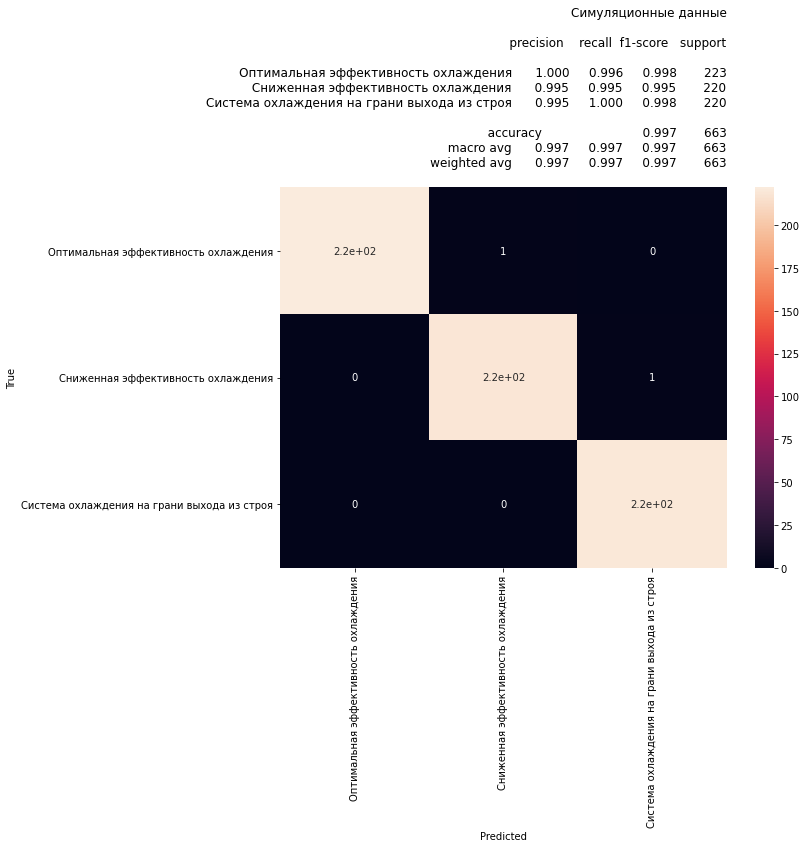

In [17]:
cf = confusion_matrix(test_labels_true, test_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = class_names, columns = class_names)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
report = classification_report(test_labels_true, test_labels_predicted, target_names=class_names, digits=3)
plt.title("Симуляционные данные\n\n" + report, loc="right");

In [15]:
def custom_classifiaction_report(true, predicted):
    class_labels = sorted(set(true))
    report_rows = []
    for cid in class_labels:
        class_true = true.copy()
        class_true[true!=cid] = 0
        class_true[true==cid] = 1
        class_predicted = predicted.copy()
        class_predicted[predicted!=cid] = 0
        class_predicted[predicted==cid] = 1
        
        accuracy = skmetrics.accuracy_score(class_true, class_predicted)
        balanced_accuracy = skmetrics.balanced_accuracy_score(class_true, class_predicted)
        precision = skmetrics.precision_score(class_true, class_predicted, average='binary')
        recall = skmetrics.recall_score(class_true, class_predicted, average='binary')
        f1 = skmetrics.f1_score(class_true, class_predicted, average='binary')
        mcc = skmetrics.matthews_corrcoef(class_true, class_predicted)
        report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    accuracy = skmetrics.accuracy_score(true, predicted)
    balanced_accuracy = skmetrics.balanced_accuracy_score(true, predicted)
    precision = skmetrics.precision_score(true, predicted, average='macro')
    recall = skmetrics.recall_score(true, predicted, average='macro')
    f1 = skmetrics.f1_score(true, predicted, average='macro')
    mcc = skmetrics.matthews_corrcoef(true, predicted)
    report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    report = pd.DataFrame(
        report_rows, 
        columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'MCC'],
        index=class_names + ['Total'] )
    
    return report


In [18]:
metrics = custom_classifiaction_report(test_labels_true, test_labels_predicted)
metrics

accuracy  balanced_accuracy  precision    recall        f1       MCC
Оптимальная эффективность охлаждения         99.849170          99.775785   1.000000  0.995516  0.997753  0.996623
Сниженная эффективность охлаждения           99.698341          99.659860   0.995455  0.995455  0.995455  0.993197
Система охлаждения на грани выхода из строя  99.849170          99.887133   0.995475  1.000000  0.997732  0.996608
Total                                        99.698341          99.699008   0.996977  0.996990  0.996980  0.995478